## 库和模型引入

In [1]:
import os
import numpy as np
import pandas as pd
import urllib.request
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage.segmentation import slic
from fast_slic import Slic
from sklearn.cluster import KMeans
from scipy.ndimage import label

from mmseg.datasets.transforms import *
from mmseg.datasets import PascalVOCDataset
from mmengine.structures import PixelData


from mmengine.config import Config, DictAction
from mmengine.runner import Runner
import itertools
import time

from modelscope import (
    snapshot_download, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
)

# torch.cuda.set_device('cuda:4')

[2023-12-04 04:21:38,033] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-12-04 04:21:41,522 - modelscope - INFO - PyTorch version 1.13.1+cu117 Found.
2023-12-04 04:21:41,524 - modelscope - INFO - Loading ast index from /home/jy/.cache/modelscope/ast_indexer
2023-12-04 04:21:41,552 - modelscope - INFO - Loading done! Current index file version is 1.9.4, with md5 388dbad55e3820c5e27f291c18f2d2a1 and a total number of 945 components indexed


导入模型

In [7]:
model_id = 'qwen/Qwen-VL-Chat'
revision = 'v1.0.0'
model_dir = '../Qwen-VL-Chat'
finetune_dir = '/home/jy/mm/Qwen-VL/output_qwen/'
model = AutoModelForCausalLM.from_pretrained(finetune_dir, device_map="cuda", trust_remote_code=True).eval()
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
if not hasattr(tokenizer, 'model_dir'):
    tokenizer.model_dir = model_dir

The model is automatically converting to fp16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".


Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

特征hook

In [3]:
feature_l = {}
handle = []
def hook_fn(layer_name, feature_l):
    def _hook_fn(m, fea_in, fea_out):
        feature_l[layer_name] = fea_out.detach().cpu()
    return _hook_fn

handle.append(model.transformer.visual.transformer.resblocks[10].register_forward_hook(hook_fn('10', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[20].register_forward_hook(hook_fn('20', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[30].register_forward_hook(hook_fn('30', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[40].register_forward_hook(hook_fn('40', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[47].register_forward_hook(hook_fn('47', feature_l)))

推理

In [9]:
img_path = '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2007_001457.jpg'
queries = ['<img>{}</img>Describe this image.'.format(img_path)]
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
responses[0]

'A living room with a black couch and a wooden coffee table. The couch has two green pillows on it and a blanket is draped over one end. There are two end tables with lamps on each side of the couch. One end table has a bowl of ornaments on it.'

In [ ]:
img_path = '/remote-home/zhangjiacheng/RVP/data/rendered_img/2007_000033/3.jpg'
prompt_template = '<img>{}</img> \
What is the most likely category of the object under the green glow? \
Choose your answer from this list: {}.'
queries = [prompt_template.format(img_path, classes_str)]
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
print (responses)

## 整理代码
空岛去除和空缺填补

In [ ]:
# K-Means Cluter
device = 'cuda:0'
# feature = hooker.fea[:, 0].cpu().float()
feature = feature_l['10'][:, 0].float()
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(feature)

/home/jy/anaconda3/envs/mm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_64774/3099354603.py:76: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  mask_imgs[masks] = img_repeated[masks]


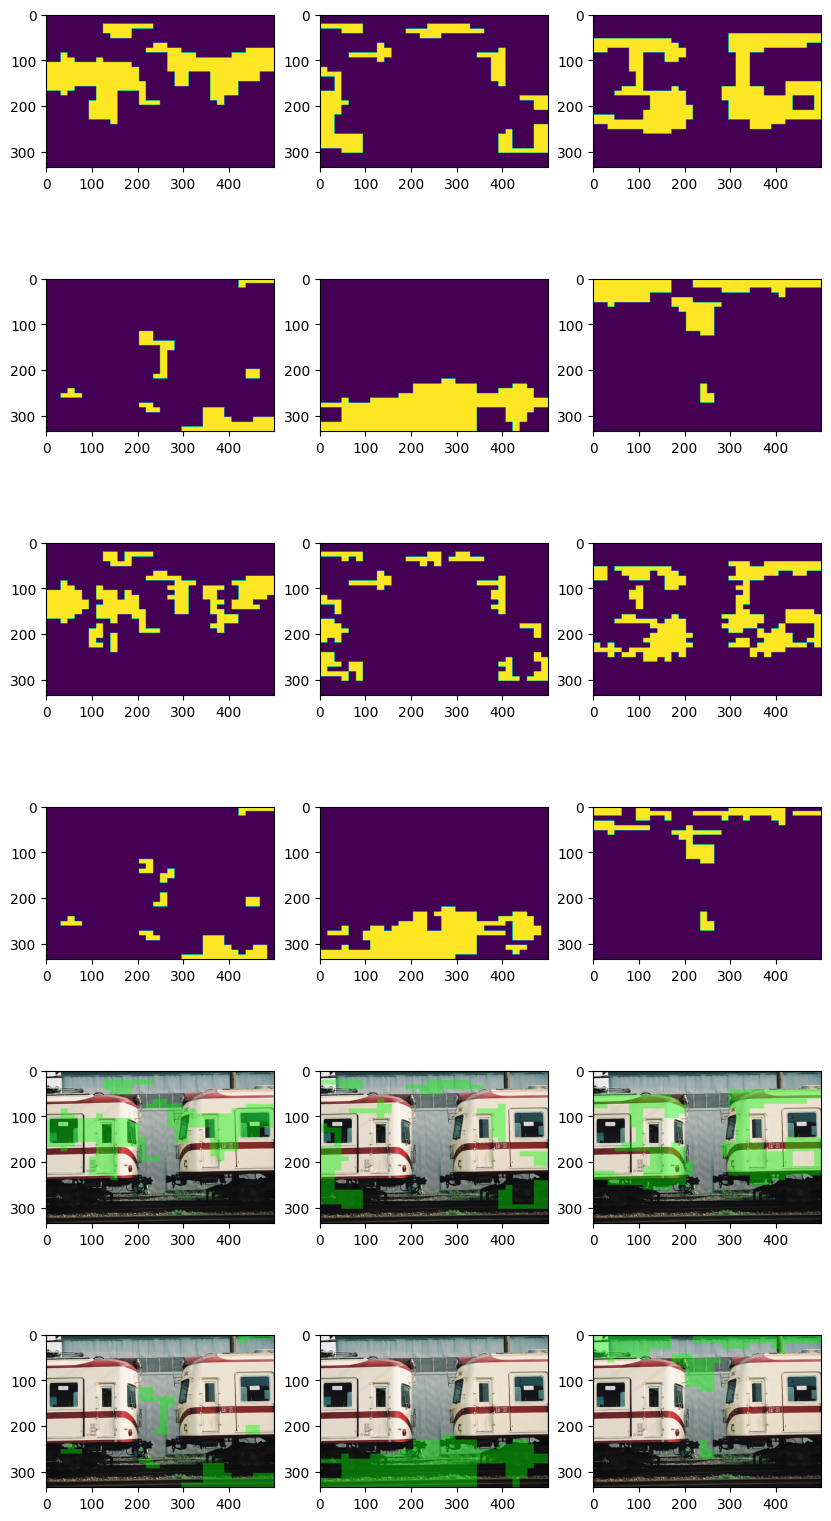

In [84]:
# K-Means Cluter
device = 'cuda:0'
# feature = hooker.fea[:, 0].cpu().float()
feature = feature_l['47'][:, 0].float()
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(feature)

cluster_img = np.zeros((448, 448, 3))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img.transpose(2, 0, 1))
H, W = img.shape[1], img.shape[2]

# for i in range(32):
#     for j in range(32):
#         patch_label = cluster_ids[i * 32 + j]
#         # color = plt.cm.tab10(patch_label / 10)
#         # cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = color[:3]
#         cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = patch_label

# superpixels_masks.shape: (ids, C, H, W)
cluster_ids = np.resize(cluster_ids, (32, 32))
masks = []
for id in np.unique(cluster_ids):
    mask = (cluster_ids == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks).byte()

# 去除空岛和空缺
structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

for mask in masks:
    l, n = label(mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 3:
            mask[lb == l] = 0

    reversed_mask = mask.logical_not()
    l, n = label(reversed_mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 10:
            mask[lb == l] = 1
tmp_masks = masks.clone()

kernel_size = 3
kernel = np.ones((kernel_size, kernel_size)).astype(np.uint8)
for i in range(masks.shape[0]):
    mask = masks[i].cpu().numpy()
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # mask = cv2.dilate(mask, kernel, iterations = 1)
    # mask = cv2.erode(mask, kernel, iterations = 1)
    masks[i] = torch.from_numpy(mask)


masks = masks[:, None].repeat(1, 3, 1, 1).to(torch.uint8).cuda()
masks = TF.resize(masks, (H, W), interpolation=InterpolationMode.NEAREST)
tmp_masks = tmp_masks[:, None].repeat(1, 3, 1, 1).to(torch.uint8).cuda()
tmp_masks = TF.resize(tmp_masks, (H, W), interpolation=InterpolationMode.NEAREST)
img_repeated = img[None].expand_as(masks).cuda()



color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

mask_imgs = torch.zeros_like(img_repeated)
remain_imgs = torch.zeros_like(img_repeated)
mask_imgs[masks] = img_repeated[masks]
remain_imgs[masks.logical_not()] = img_repeated[masks.logical_not()]

# Render images
# Mix-up (Background brightness unchanged)
color_mode = 'G'
if color_mode == 'R':
    rendered_imgs = (mask_imgs * 0.6 + masks * Red * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Red * 0.4
elif color_mode == 'G':
    rendered_imgs = (mask_imgs * 0.6 + masks * Green * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Green * 0.4
elif color_mode == 'B':
    rendered_imgs = (mask_imgs * 0.6 + masks * Blue * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Blue * 0.4
else:
    raise ValueError('Color not supported: {}'.format(color_mode))

fig, axes = plt.subplots(6, 3, figsize=(10, 20))
# axes[0, 0].imshow(rendered_imgs[0].permute(1, 2, 0).cpu().to(torch.uint8))
axes[0, 0].imshow(masks[0, 0].cpu().numpy())
axes[0, 1].imshow(masks[1, 0].cpu().numpy())
axes[0, 2].imshow(masks[2, 0].cpu().numpy())
axes[1, 0].imshow(masks[3, 0].cpu().numpy())
axes[1, 1].imshow(masks[4, 0].cpu().numpy())
axes[1, 2].imshow(masks[5, 0].cpu().numpy())
axes[2, 0].imshow(tmp_masks[0, 0].cpu().numpy())
axes[2, 1].imshow(tmp_masks[1, 0].cpu().numpy())
axes[2, 2].imshow(tmp_masks[2, 0].cpu().numpy())
axes[3, 0].imshow(tmp_masks[3, 0].cpu().numpy())
axes[3, 1].imshow(tmp_masks[4, 0].cpu().numpy())
axes[3, 2].imshow(tmp_masks[5, 0].cpu().numpy())
axes[4, 0].imshow(rendered_imgs[0].permute(1, 2, 0).cpu().to(torch.uint8))
axes[4, 1].imshow(rendered_imgs[1].permute(1, 2, 0).cpu().to(torch.uint8))
axes[4, 2].imshow(rendered_imgs[2].permute(1, 2, 0).cpu().to(torch.uint8))
axes[5, 0].imshow(rendered_imgs[3].permute(1, 2, 0).cpu().to(torch.uint8))
axes[5, 1].imshow(rendered_imgs[4].permute(1, 2, 0).cpu().to(torch.uint8))
axes[5, 2].imshow(rendered_imgs[5].permute(1, 2, 0).cpu().to(torch.uint8))

In [41]:
mask.shape

(32, 32)

In [44]:
cv2.dilate(mask.astype(np.uint8), kernel, iterations = 1)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

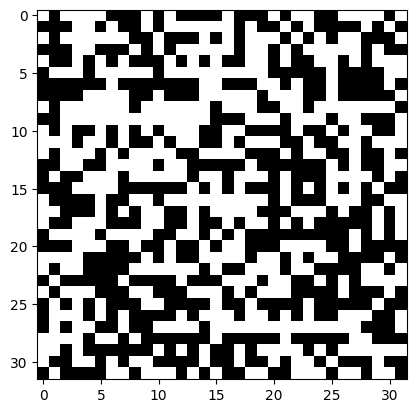

In [38]:
m = torch.randint(0, 2, size=(32, 32), dtype=torch.uint8)
plt.imshow(m[..., None], cmap='gray', interpolation='none')

## GT处理

### 导入config和val_datalodaer

In [2]:
class SimulateArgs:
    def __init__(self):
        self.config = '../mmsegmentation/my_configs/pascal_voc12_base.py'
        self.launcher = 'none'
        self.cfg_options = None
        self.work_dir = None
        self.checkpoint = None
        self.tta = False
        self.out = None

args = SimulateArgs()


# load config
cfg = Config.fromfile(args.config)
cfg.launcher = args.launcher
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = os.path.join('./work_dirs',
                            os.path.splitext(os.path.basename(args.config))[0])

cfg.load_from = args.checkpoint

# if args.show or args.show_dir:
#     cfg = trigger_visualization_hook(cfg, args)

if args.tta:
    cfg.test_dataloader.dataset.pipeline = cfg.tta_pipeline
    cfg.tta_model.module = cfg.model
    cfg.model = cfg.tta_model

# add output_dir in metric
if args.out is not None:
    cfg.test_evaluator['output_dir'] = args.out
    cfg.test_evaluator['keep_results'] = True

In [3]:
runner = Runner.from_cfg(cfg)
loader = runner.val_dataloader
evaluator = runner.val_evaluator

runner.call_hook('before_val')
runner.call_hook('before_val_epoch')
runner.model.eval()

# data_sample = next(iter(loader))
# for data_sample in loader:
#     img_path = data_sample['data_samples'][0].img_path
#     img_name = img_path.split('/')[-1].split('.')[0]
#     if img_name == '2008_006981':
#         break

12/04 04:22:07 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.18 (main, Sep 11 2023, 13:41:44) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 884805143
    GPU 0,1,2,3,4,5,6,7: Tesla V100S-PCIE-32GB
    CUDA_HOME: /home/jy/apps/cuda-11.7
    NVCC: Cuda compilation tools, release 11.7, V11.7.64
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch

/home/jy/mm/RVP/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/04 04:22:12 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
12/04 04:22:12 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): _BatchNormXd(64, eps=

标准的gt单个样本render

In [71]:
gt_mask_dir = '/home/jy/mm/RVP/data/gt_masks'
for data_sample in loader:
    img_name = data_sample['data_samples'][0].img_path.split('/')[-1].split('.')[0]
    mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    mask[mask == 255] = 0
    np.save(os.path.join(gt_mask_dir, '{}.npy'.format(img_name)), mask.numpy())

In [72]:
from scipy.io import loadmat
basedir = '/home/jy/mm/tmp_data2/sbd/raw/benchmark_RELEASE/dataset/cls/'
savedir = '/home/jy/mm/RVP/data/gt_masks'
mask_names = sorted(os.listdir(basedir))
for mask_name in mask_names:
    mask_name = mask_name.split('.')[0]
    data = loadmat(os.path.join(basedir, mask_name))
    data = data['GTcls'][0][0][1][None]
    np.save(os.path.join(savedir, mask_name), data)

torch.Size([1, 375, 500])


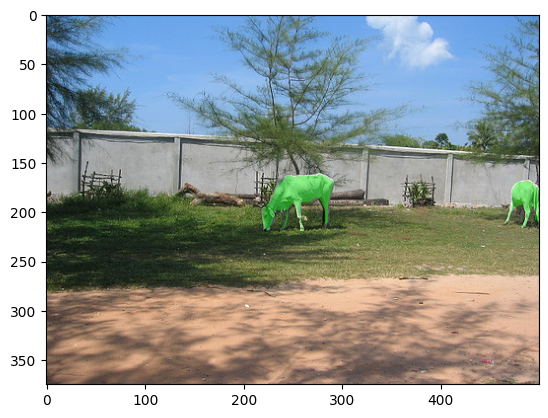

In [67]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]) # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

# img = cv2.imread(data_sample['data_samples'][0].img_path)
img = cv2.imread('/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2008_000009.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img)[None].permute(0, 3, 1, 2)


# mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
mask = torch.from_numpy(data[None])
mask = torch.from_numpy(np.load('/home/jy/mm/RVP/data/gt_masks/2008_000009.npy'))
print (mask.shape)
mask[mask == 255] = 0
# mask[mask != 0] = 1
mask = mask[:, None].repeat(1, 3, 1, 1).bool()

mask_img = torch.zeros_like(img)
remain_img = torch.zeros_like(img)
mask_img[mask] = img[mask]
remain_img[mask.logical_not()] = img[mask.logical_not()]

# rendered_img = mask * Green * 0.4 + img * 0.6
rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
plt.imshow(rendered_img[0].permute(1, 2, 0).cpu().to(torch.uint8))

用point prompt在单个样本上构造，测试

torch.Size([1, 3, 500, 500])

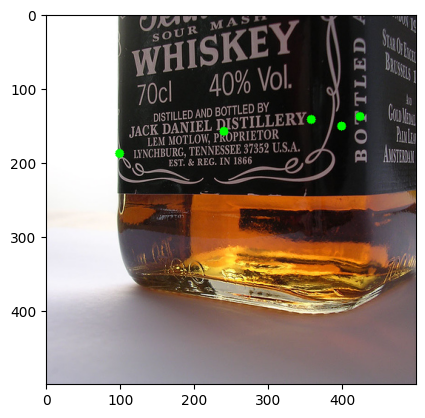

In [92]:
coords = torch.nonzero(mask)
n = min(5, coords.shape[0])
sampled_coords = coords[torch.randperm(coords.shape[0])[:n]]
pnt_img = img[0].clone().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
for _, _, y, x in sampled_coords:
    cv2.circle(pnt_img, (int(x), int(y)), 6, (0, 255, 0), -1)
plt.imshow(pnt_img)
mask.shape

img shape: torch.Size([1, 3, 366, 500])


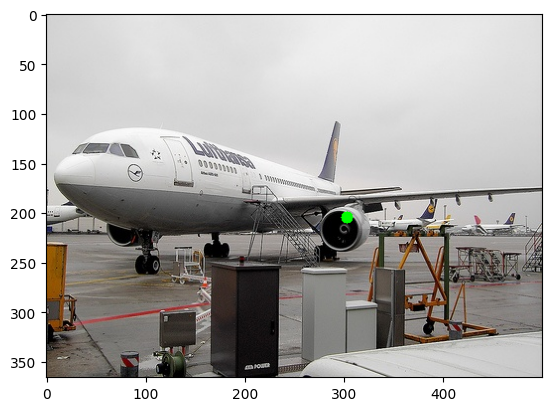

In [45]:
img = cv2.imread(data_sample['data_samples'][0].img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
print (f'img shape: {img.shape}')

mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
# 处理后的mask只有0和1
mask[mask == 255] = 0
mask[mask != 0] = 1
mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

# 计算质心的方法
_, _, H, W = mask.shape
y_coords = torch.arange(H)[None, None, :, None].expand_as(mask).cuda()
x_coords = torch.arange(W)[None, None, None, :].expand_as(mask).cuda()
y_weighted = mask * y_coords
x_weighted = mask * x_coords
y_center = y_weighted.sum(dim=(2, 3)) / torch.where(y_weighted != 0, 1, 0).sum(dim=(2, 3))
x_center = x_weighted.sum(dim=(2, 3)) / torch.where(x_weighted != 0, 1, 0).sum(dim=(2, 3))

rendered_img = img[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
# cv2.circle(rendered_img, (int(np.round(x_center[0][0].item())), int(np.round(y_center[0][0].item()))), 6, (0, 255, 0), -1)
coords = torch.nonzero(mask)
rand_coords = coords[torch.randint(0, len(coords), (1, ))][0]
ry, rx = rand_coords[2], rand_coords[3]
cv2.circle(rendered_img, (rx.item(), ry.item()), 6, (0, 255, 0), -1)
plt.imshow(rendered_img)

### GT数据集伪造

#### 处理数据集并保存

添加随机噪声

In [ ]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_name = []
os.makedirs('../data/voc_gt_modified', exist_ok=True)
for data_sample in loader:
    gt_mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    resized_mask = TF.resize(gt_mask, (448, 448), interpolation=InterpolationMode.NEAREST)
    # resized_mask[(resized_mask < 255) & (resized_mask != 0)] = 1
    resized_mask[resized_mask == 255] = 0
    print (torch.unique(resized_mask))

    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
    
    save_dir_name = os.path.join('../data/voc_gt_modified', img_name)
    os.makedirs(save_dir_name, exist_ok=True)

    ## 按标签存
    for l in torch.unique(resized_mask):
        if (l == 0):
            continue
        label = l.item()
        
        ptr = torch.zeros(32, 32, dtype=torch.bool)
        ptr_mask = torch.rand(32, 32) < 0.06
        for i in range(32):
            for j in range(32):
                lbl = torch.unique(resized_mask[0, i*14:(i+1)*14, j*14:(j+1)*14])
                if torch.any(lbl == label): 
                    ptr[i, j] = True
        ptr[ptr_mask] ^= True

        mask = TF.resize(ptr[None], (gt_mask.shape[1], gt_mask.shape[2]), interpolation=InterpolationMode.NEAREST)
        mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

        mask_img = torch.zeros_like(img).cuda()
        remain_img = torch.zeros_like(img).cuda()
        mask_img[mask] = img[mask]
        remain_img[mask.logical_not()] = img[mask.logical_not()]

        # rendered_img = mask * Green * 0.4 + img * 0.6
        rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
        rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
        rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite(os.path.join(save_dir_name, str(label)+'.jpg'), rendered_img)


更细粒度的在gt上添加噪声

In [5]:
def add_squares(mask, num_squares, square_size):
    """
    背景区域（mask中为0的区域）添加1的方块
    Args:
        mask (_type_): _description_
        num_squares (_type_): _description_
        square_size (_type_): _description_

    Returns:
        _type_: _description_
    """
    mask = mask.clone().numpy().astype(np.uint8)
    coords = np.column_stack(np.nonzero(mask == 0))
    mask = np.zeros_like(mask).astype(np.uint8)
    rows, cols = mask.shape
    rand_ids = torch.randperm(len(coords))[:num_squares]
    
    for idx in rand_ids:
        # x, y = np.random.randint(cols - square_size), np.random.randint(rows - square_size)
        # rand_idx = np.random.randint(0, len(coords) - 1)
        y, x = coords[idx]
        y, x = min(rows - square_size, y), min(cols - square_size, x)
        if mask[y, x] == 0:  # 只在背景区域添加方块
            cv2.rectangle(mask, (x, y), (x + square_size, y + square_size), (1, ), thickness=-1)
    return torch.from_numpy(mask)

def remove_squares(mask, num_squares, square_size):
    """
    前景区域（mask中为1的区域）添加0的方块
    Args:
        mask (_type_): _description_
        num_squares (_type_): _description_
        square_size (_type_): _description_

    Returns:
        _type_: _description_
    """
    mask = mask.clone().numpy().astype(np.uint8)
    coords = np.column_stack(np.nonzero(mask == 1))
    rows, cols = mask.shape
    rand_ids = torch.randperm(len(coords))[:num_squares]

    for idx in rand_ids:
        # x, y = np.random.randint(cols - square_size), np.random.randint(rows - square_size)
        # rand_idx = np.random.randint(0, len(coords) - 1)
        y, x = coords[idx]
        y, x = min(rows - square_size, y), min(cols - square_size, x)
        if mask[y, x] == 1:  # 只在前景区域移除方块
            cv2.rectangle(mask, (x, y), (x + square_size, y + square_size), (0, ), thickness=-1)
    return torch.from_numpy(mask)

color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_name = []
os.makedirs('../data/voc_gt_modified', exist_ok=True)

for data_sample in loader:
    gt_mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    resized_mask = TF.resize(gt_mask, (448, 448), interpolation=InterpolationMode.NEAREST)
    # resized_mask[(resized_mask < 255) & (resized_mask != 0)] = 1
    resized_mask[resized_mask == 255] = 0

    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()

    save_dir_name = os.path.join('../data/voc_gt_modified', img_name)
    os.makedirs(save_dir_name, exist_ok=True)

    ## 按标签存
    for l in torch.unique(resized_mask):
        if (l == 0):
            continue
        label = l.item()
        
        ptr = torch.zeros(32, 32, dtype=torch.bool)
        for i in range(32):
            for j in range(32):
                lbl = torch.unique(resized_mask[0, i*14:(i+1)*14, j*14:(j+1)*14])
                if torch.any(lbl == label): 
                    ptr[i, j] = True
        tmp_ptr = ptr.to(torch.uint8)
        # ptr_mask = torch.rand(32, 32) < 0.06
        # ptr[ptr_mask] ^= True
        ptr_1_sum = torch.sum(ptr == 1).item()
        ptr_0_sum = torch.sum(ptr == 0).item()
        # ptr = add_squares(ptr, num_squares=np.floor(ptr_0_sum * 0.).astype(int), square_size=0)
        # ptr = remove_squares(ptr, num_squares=np.floor(ptr_1_sum * 100).astype(int), square_size=0)
        # ptr = add_squares(ptr, num_squares=20, square_size=0)
        ptr = add_squares(ptr, num_squares=np.floor(ptr_0_sum * 0.02).astype(int), square_size=2) | remove_squares(ptr, num_squares=np.floor(ptr_1_sum * 0.1).astype(int), square_size=1)
        
        mask = TF.resize(ptr[None], (gt_mask.shape[1], gt_mask.shape[2]), interpolation=InterpolationMode.NEAREST)
        mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

        mask_img = torch.zeros_like(img).cuda()
        remain_img = torch.zeros_like(img).cuda()
        mask_img[mask] = img[mask]
        remain_img[mask.logical_not()] = img[mask.logical_not()]


        rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
        rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
        rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite(os.path.join(save_dir_name, str(label)+'.jpg'), rendered_img)
    
    # 存背景
    ptr = torch.zeros(32, 32, dtype=torch.bool)
    for i in range(32):
        for j in range(32):
            if torch.any(resized_mask[0, i*14:(i+1)*14, j*14:(j+1)*14] != 0): 
                ptr[i, j] = True
    reversed_ptr = ptr.logical_not().to(torch.uint8)
    removed_reversed_ptr = remove_squares(reversed_ptr, num_squares=np.floor(torch.sum(reversed_ptr == 1).item() * 0.2).astype(int), square_size=1)
    added_reversed_ptr = add_squares(reversed_ptr, num_squares=np.floor(torch.sum(reversed_ptr == 0.2).item() * 0.1).astype(int), square_size=2)
    reversed_ptr = added_reversed_ptr | removed_reversed_ptr
    
    mask = TF.resize(reversed_ptr[None], (gt_mask.shape[1], gt_mask.shape[2]), interpolation=InterpolationMode.NEAREST)
    mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

    mask_img = torch.zeros_like(img).cuda()
    remain_img = torch.zeros_like(img).cuda()
    mask_img[mask] = img[mask]
    remain_img[mask.logical_not()] = img[mask.logical_not()]

    rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
    rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
    rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(os.path.join(save_dir_name, '0.jpg'), rendered_img)
    

# plt.imshow(rendered_img)
# fig, axes = plt.subplots(1, 2, figsize=(5, 10))
# axes[0].imshow(tmp_ptr, cmap='gray', interpolation='none')
# axes[1].imshow(ptr, cmap='gray', interpolation='none')

在gt上构造point prompt数据集

SBD训练集

In [101]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

names = []
with open('/home/jy/mm/RVP/data/VOCdevkit/VOC2012/ImageSets/Segmentation/trainaug.txt', 'r') as file:
    for line in file:
        names.append(line.replace('\n', ''))

maskdir = '/home/jy/mm/RVP/data/gt_masks'
imgdir = '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages'
mask_names = sorted(os.listdir(maskdir))
os.makedirs('../data/voc_gt_modified', exist_ok=True)
for name in names:
    mask = torch.from_numpy(np.load(os.path.join(maskdir, '{}.npy'.format(name)))).cuda()
    img = cv2.imread(os.path.join(imgdir, '{}.jpg'.format(name)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
    
    savedir = os.path.join('../data/voc_gt_modified/', name)
    os.makedirs(savedir, exist_ok=True)
    
    for l in torch.unique(mask):
        l = l.item()
        class_mask = (mask == l).cuda().byte()
        coords = torch.nonzero(class_mask)
        rand_coords = coords[torch.randint(2, len(coords), (1, ))]
        
        for i in range(rand_coords.shape[0]):
            ry, rx = rand_coords[i, 1], rand_coords[i, 2]
            
            # rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
            rendered_img = img.clone()[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            cv2.circle(rendered_img, (rx.item(), ry.item()), 6, (0, 255, 0), -1)
            rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(savedir, '{}_{}.jpg'.format(l, i)), rendered_img)

In [105]:
len(os.listdir('/home/jy/mm/RVP/data/voc_gt_modified'))

10582

voc标准训练集

In [73]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_name = []
os.makedirs('../data/voc_gt_modified', exist_ok=True)

for data_sample in loader:
    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()

    mask = data_sample['data_samples'][0].gt_sem_seg.data.clone().cuda()
    mask[mask == 255] = 0
    
    save_dir_name = os.path.join('../data/voc_gt_modified', img_name)
    os.makedirs(save_dir_name, exist_ok=True)

    ## 按标签存
    for l in torch.unique(mask):
        l = l.item()
        class_mask = (mask == l).cuda().to(torch.uint8)
        coords = torch.nonzero(class_mask)
        rand_coords = coords[torch.randint(2, len(coords), (1, ))]
        for i in range(rand_coords.shape[0]):
            ry, rx = rand_coords[i, 1], rand_coords[i, 2]
            
            # rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
            rendered_img = img.clone()[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            cv2.circle(rendered_img, (rx.item(), ry.item()), 6, (0, 255, 0), -1)
            rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(save_dir_name, '{}_{}.jpg'.format(l, i)), rendered_img)

#### 构造json文件

In [103]:
# classes=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
#         'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
#         'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
#         'sofa', 'train', 'tvmonitor']
classes=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person']
classes_str = ""
for name in classes:
    classes_str += (name + ", ")
classes_str = classes_str[:-2]

name2id, id2name = dict(), dict()

for id, class_name in enumerate(classes):
    name2id[class_name] = id
    id2name[id] = class_name
id2name

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person'}

In [104]:
# prompt_template = '<img>{}</img> \
# What is the most likely category of the object under the green glow? \
# Choose your answer from this list: {}.'
prompt_template = '<img>{}</img> \
What is the most likely category of the object marked by the green dot? \
Choose your answer from this list: {}.'
json_list = []
basedir = '/home/jy/mm/RVP/data/voc_gt_modified'
imgdirs = os.listdir(basedir)
cnt = 0
for img_name in imgdirs:
    imgdir = os.path.join(basedir, img_name)
    img_names = os.listdir(imgdir)
    ids = np.array([int(x.split('.')[0].split('_')[0]) for x in img_names])
    if np.any(ids > 15):
        continue
    
    for img_name in img_names:
        id = int(img_name.split('.')[0].split('_')[0])
        
        img_path = os.path.join(imgdir, img_name)
        dic = {
            "id": "identity_{}".format(cnt),
            "conversations": [
                {
                    "from": "user",
                    "value": prompt_template.format(img_path, classes_str)
                },
                {
                    "from": "assistant",
                    "value": "{}".format(id2name[id])
                }
            ]
        }
        cnt += 1
        json_list.append(dic)

with open('data.json', 'w') as file:
    json.dump(json_list, file, indent=4)

In [93]:
fs = os.listdir('/home/jy/mm/RVP/data/voc_gt_modified')
len(fs)

1464

### 展示GT数据

In [ ]:
data_sample = next(val_dataloader)
img = cv2.imread(data_sample['data_samples'][0].img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
print (torch.unique(mask))
# mask[(mask < 255) & (mask != 0)] = 1
print (torch.unique(mask))
print (mask.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[1].imshow(mask[0], cmap='gray', interpolation='none')


## 获取CC12M数据集数据

In [ ]:
# 使用pandas读取TSV文件
data = pd.read_csv('../data/cc12m.tsv', sep='\t', header=None)

In [ ]:
random_data = data.sample(n=2000, random_state=1234)
random_data.iloc[0][0]
random_data.columns = ['website', 'caption']

In [ ]:
data = pd.read_csv('cc12.csv')
if not os.path.exists('../data/cc12'):
    os.makedirs('../data/cc12')

failed_list = []
for idx, row in data.iterrows():
    url = row['website']
    print (f'{idx}: {url}')
    
    try:
        img_response = urllib.request.urlopen(url)
        img_array = np.array(bytearray(img_response.read()), dtype=np.uint8)
        img = cv2.imdecode(img_array, -1)
        
        file_path = os.path.join('../data/cc12', '{}.jpg'.format(idx))
        cv2.imwrite(file_path, img)
    except:
        failed_list.append(idx)
print (failed_list)

# 计算指标

point prompt预测准确率

In [38]:
total = 0
right = 0
for data_sample in loader:
    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    gt_mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    pred = np.load(os.path.join('../data/sem_seg_preds/scikit30/G/', '{}.npy'.format(img_name)))
    pred = torch.from_numpy(pred)
    total += torch.nonzero(pred).shape[0]
    for pos in zip(*torch.nonzero(pred, as_tuple=True)):
        if (pred[pos] == 255):
            pred[pos] = 0
        if (pred[pos] == gt_mask[pos]):
            right += 1

print (right / total)

0.7691879866518354


In [10]:
len(os.listdir('/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages'))

17125